## Image description and labels based on the image link - based on Hugging Face's Image Captioning model

In [15]:
import requests
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration
import torch

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large").to(device)
     

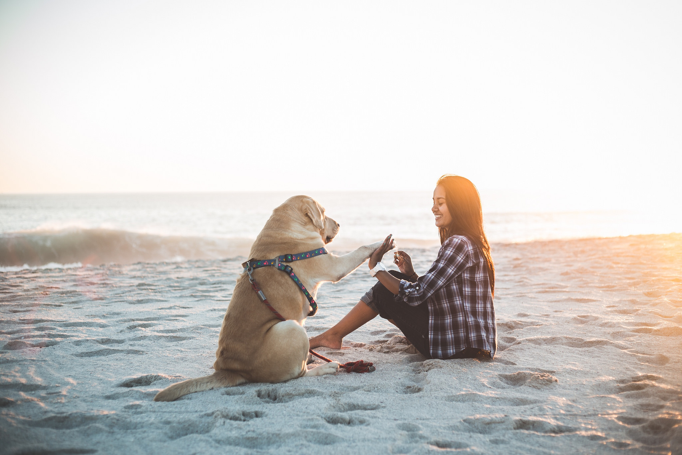

In [18]:
img_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg' 
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')
# resize the image to half its original size
resized_image = raw_image.resize((int(raw_image.width / 3), int(raw_image.height / 3)))
resized_image

In [19]:
# conditional image captioning
text = "a photography of"
inputs = processor(raw_image, text, return_tensors="pt").to("cuda")

In [20]:
out = model.generate(**inputs)
print(processor.decode(out[0], skip_special_tokens=True, max_new_tokens=50))

/home/jarek/.virtualenvs/higging_face/lib/python3.8/site-packages/transformers/generation/utils.py:1346: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


a photography of a woman and her dog on the beach


In [21]:
# unconditional image captioning
inputs = processor(raw_image, return_tensors="pt").to("cuda")

In [22]:
out = model.generate(**inputs)
print(processor.decode(out[0], skip_special_tokens=True))

woman sitting on the beach with her dog and a cell phone


## Image description and labels based on the image link - based on Hugging Face's Image Captioning and OpenAI models with LangChain

In [1]:
import torch
from transformers import BlipProcessor, BlipForConditionalGeneration

hf_model = "Salesforce/blip-image-captioning-large"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

processor = BlipProcessor.from_pretrained(hf_model)
model = BlipForConditionalGeneration.from_pretrained(hf_model).to(device)

/home/jarek/.virtualenvs/higging_face/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


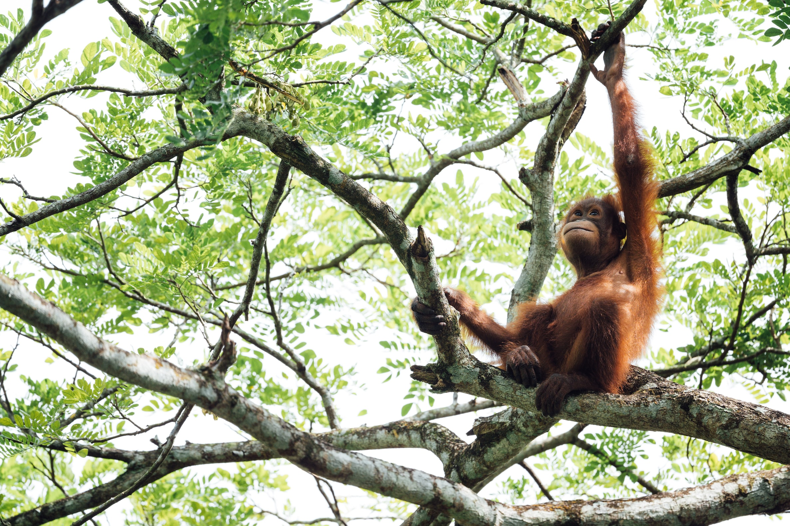

In [2]:
import requests
from PIL import Image

img_url = 'https://images.unsplash.com/photo-1616128417859-3a984dd35f02?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=2372&q=80' 
image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')
resized_image = image.resize((int(image.width / 3), int(image.height / 3)))
resized_image
     


In [3]:
# unconditional image captioning
inputs = processor(image, return_tensors="pt").to(device)

out = model.generate(**inputs, max_new_tokens=20)
print(processor.decode(out[0], skip_special_tokens=True))

there is a monkey that is sitting in a tree


In [4]:
import os
OPENAI_API_KEY = os.environ.get('OPENAI_API_KEY') or 'OPENAI_API_KEY'

In [5]:
from langchain.chat_models import ChatOpenAI
from langchain.chains.conversation.memory import ConversationBufferWindowMemory

from langchain.tools import BaseTool
from math import pi
from typing import Union

from langchain.agents import initialize_agent

# initialize LLM
llm = ChatOpenAI(
    openai_api_key=OPENAI_API_KEY,
    temperature=0,
    model_name='gpt-3.5-turbo'
)
# initialize conversational memory
conversational_memory = ConversationBufferWindowMemory(
    memory_key='chat_history',
    k=5,
    return_messages=True
)

In [6]:
desc = (
    "use this tool when given the URL of an image that you'd like to be "
    "described. It will return a simple caption describing the image."
)

class ImageCaptionTool(BaseTool):
    name = "Image captioner"
    description = desc

    def _run(self, url: str):
        # download the image and convert to PIL object
        image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')
        # preprocess the image
        inputs = processor(image, return_tensors="pt").to("cuda")
        # generate the caption
        out = model.generate(**inputs, max_new_tokens=20)
        # get the caption
        caption = processor.decode(out[0], skip_special_tokens=True)
        return caption
    
    def _arun(self, query: str):
        raise NotImplementedError("This tool does not support async")

tools = [ImageCaptionTool()]



In [7]:
sys_msg = """Assistant is a large language model trained by OpenAI.

Assistant is designed to be able to assist with a wide range of tasks, from answering simple questions to providing in-depth explanations and discussions on a wide range of topics. As a language model, Assistant is able to generate human-like text based on the input it receives, allowing it to engage in natural-sounding conversations and provide responses that are coherent and relevant to the topic at hand.

Assistant is constantly learning and improving, and its capabilities are constantly evolving. It is able to process and understand large amounts of text, and can use this knowledge to provide accurate and informative responses to a wide range of questions. Additionally, Assistant is able to generate its own text based on the input it receives, allowing it to engage in discussions and provide explanations and descriptions on a wide range of topics.

Overall, Assistant is a powerful system that can help with a wide range of tasks and provide valuable insights and information on a wide range of topics. Whether you need help with a specific question or just want to have a conversation about a particular topic, Assistant is here to assist.
"""

# initialize agent with tools
agent = initialize_agent(
    agent='chat-conversational-react-description',
    tools=tools,
    llm=llm,
    verbose=True,
    max_iterations=3,
    early_stopping_method='generate',
    memory=conversational_memory
)

new_prompt = agent.agent.create_prompt(
    system_message=sys_msg,
    tools=tools
)

agent.agent.llm_chain.prompt = new_prompt
# update the agent tools
agent.tools = tools    


In [8]:
agent(f"What does this image show?\n{img_url}")



> Entering new AgentExecutor chain...
{
    "action": "Image captioner",
    "action_input": "https://images.unsplash.com/photo-1616128417859-3a984dd35f02?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=2372&q=80"
}
Observation: there is a monkey that is sitting in a tree
Thought:{
    "action": "Final Answer",
    "action_input": "The image shows a monkey sitting in a tree."
}

> Finished chain.


{'input': 'What does this image show?\nhttps://images.unsplash.com/photo-1616128417859-3a984dd35f02?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=2372&q=80',
 'chat_history': [],
 'output': 'The image shows a monkey sitting in a tree.'}

In [9]:
picture_description = agent(f"What does this image show?\n{img_url}")



> Entering new AgentExecutor chain...
{
    "action": "Image captioner",
    "action_input": "https://images.unsplash.com/photo-1616128417859-3a984dd35f02?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=2372&q=80"
}
Observation: there is a monkey that is sitting in a tree
Thought:{
    "action": "Final Answer",
    "action_input": "The image shows a monkey sitting in a tree."
}

> Finished chain.


In [11]:
picture_description["output"]

'The image shows a monkey sitting in a tree.'

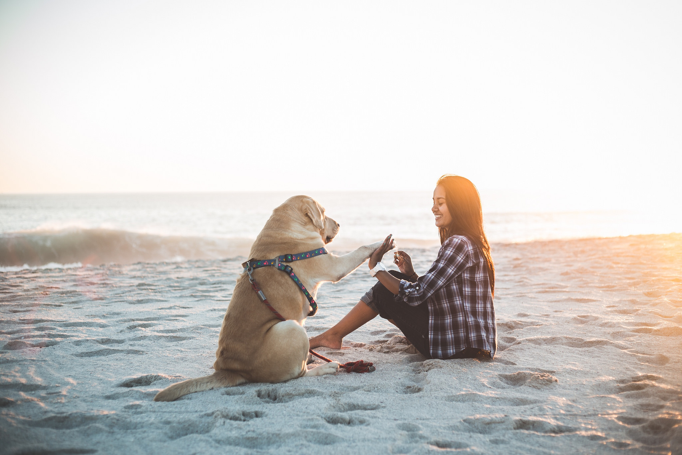

In [12]:
img_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg' 
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')
# resize the image to half its original size
resized_image = raw_image.resize((int(raw_image.width / 3), int(raw_image.height / 3)))
resized_image

In [13]:
picture_description = agent(f"What does this image show?\n{img_url}")



> Entering new AgentExecutor chain...
{
    "action": "Image captioner",
    "action_input": "https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg"
}
Observation: woman sitting on the beach with her dog and a cell phone
Thought:{
    "action": "Final Answer",
    "action_input": "The image at https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg shows a woman sitting on the beach with her dog and a cell phone."
}

> Finished chain.


In [14]:
picture_description["output"]

'The image at https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg shows a woman sitting on the beach with her dog and a cell phone.'